In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv as kcv
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbCallback, WandbModelCheckpoint, WandbEvalCallback
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import BatchNormalization, Input
from keras.applications import VGG16
from keras import Model
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory
from keras.applications import EfficientNetB0, ResNet50V2, ConvNeXtBase
from keras.losses import CategoricalCrossentropy
from keras.optimizers import RMSprop, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.callbacks import Callback
from collections import Counter
from sklearn.utils import class_weight

rand_augment = kcv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    geometric=True,
    rate=0.7,
    )

cut_mix = kcv.layers.CutMix()
mix_up = kcv.layers.MixUp()

le = LabelEncoder()
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'

2024-05-21 15:42:42.154756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:42:42.154800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:42:42.156313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 15:42:42.164318: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


2024-05-21 15:42:54.939072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:db:00.0, compute capability: 7.0


# 偵測系統中的 GPU 個數

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 超參數

In [3]:
configs = dict(
    train_dir = '你的資料夾網址',
    train_csv = '你的資料夾網址',
    num_classes = 3,
    batch_size = 32,
    image_size = (224, 224),
    earlystopping_patience = 3,
    warmup_learning_rate = 1e-3,
    initial_learning_rate = 1e-4,
    epochs = 3,
    test_dir = ' 你的資料夾網址',
    
    model_name = 'resnet50', #resnet50, efficientnet
    advanced_aug = 'none', # none, cutmix, mixup, or cutmix_mixup 
    seed = 42, # the random seed
)
# 儲存 label名稱，和 label id 的對照表 (之後要建立 submission 檔用的)
LABEL_TBL = 'label_table.csv'
AUTO = tf.data.AUTOTUNE

# Reproducibility

指定種子，讓實驗可以重現

In [4]:
keras.utils.set_random_seed(configs['seed'])

# 資料的特性

In [5]:
def update_img_name(row, path):
    """
    本函式會把每張圖片加上路徑
    """
    return f'{path}/{row.image_id}'


## Label ecnoder

使用 laber encoder 將 comment 編碼成數字

In [6]:
# check whether dffiles.image_id exists in folder configs['train_dir']
def check_image_exist(row):
    return os.path.exists(row.image_id)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dffiles = pd.read_csv(configs['train_csv'])
dffiles['label'] = le.fit_transform(dffiles.label)
dffiles.head()

,image_id,label
0,00002.jpg,2
1,00003.jpg,2
2,00004.jpg,1
3,00005.jpg,0
4,00007.jpg,0


In [8]:
le.classes_

array(['A', 'B', 'C'], dtype=object)

In [9]:
label_name = le.classes_
label_id = le.transform(le.classes_)
df = pd.DataFrame({
    'label_name':label_name,
    'label_id':label_id
})
df.to_csv(LABEL_TBL, index=None)
df.head()

,label_name,label_id
0,A,0
1,B,1
2,C,2


In [10]:
dffiles.label.value_counts(normalize=True)

1    0.369286
0    0.320000
2    0.310714
Name: label, dtype: float64

# Goal

由於資料不平衡 (imbalance)，因此我們研究的目的在於，是否可以應用一些技巧，解決資料不平衡的問題，並且讓模型的效能得以提升。

研究的 metrics 為 accuracy rate

- Experiment 1: baseline，使用三個模型，加上 data augmentation 的技巧，試著做運動的影像分類。這三個模型是 resent50, efficientb0, 以及 ConvNeXtBase。這個實驗中，沒有使用任何解決 imbalance 的技巧，所以應該是效能最差的一個結果。因此底下其他的實驗都可以跟這個 baseline，看效能有沒有提升。
- Experiment 2:  使用 CutMix，CutOut 的 image augmentation 技巧，讓資料得以平衡。看能不能提升效能。

In [12]:
le = LabelEncoder()

# 函式

這一節定義了一些重要的函式，之後要呼叫它們。

In [13]:
preprocess_map = {
    'efficientnetb0': keras.applications.efficientnet.preprocess_input,
    'resnet50': keras.applications.resnet_v2.preprocess_input,
    'convnextbase': keras.applications.convnext.preprocess_input 
}

def get_preprocess_func(model_name):
    return preprocess_map[model_name]

In [14]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_image(file_bytes, channels=3, expand_animations = False) 
    image = tf.image.resize(image, configs['image_size'][:2], method="bilinear")
    image = tf.cast(image, tf.float32) 
    
    if label is not None:
        label = tf.one_hot(label, configs['num_classes'])
    
    #label = tf.cast(label, tf.float32)
    if label is not None:
        return {"images": image, "labels": label}
    else:
        return {"images": image}

In [15]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(10, 10)).suptitle(title, fontsize=14)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples[0]
        labels = samples[1] 
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy())
        # draw the one-hot label on the top of image
        label = ','.join([str(f'{i:.2f}') for i in labels[0].numpy()])

        plt.title(f'[{label}]', fontsize=10)
        plt.axis("off")
    plt.show()


## 資料擴增

In [16]:
def apply_base_augmentation(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

def apply_cutmix_augmentation(inputs):
    inputs = cut_mix(inputs, training=True)
    return inputs

def apply_mixup_augmentation(inputs):
    inputs = mix_up(inputs, training=True)
    return inputs

def apply_cutmix_mixup_augmentation(inputs):
    inputs = cut_mix(inputs, training=True)
    inputs = mix_up(inputs, training=True)  
    return inputs

## 讀取資料

In [17]:
def get_train_val_dataframes(filename, test_size=0.2):
    dffiles = pd.read_csv(filename)
    dffiles.image_id = dffiles.apply(update_img_name, args=(configs['train_dir'],), axis=1)
    dffiles['label'] = le.fit_transform(dffiles.label)
    x=dffiles.image_id
    y=dffiles.label
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=test_size,random_state=0,stratify=y)
    dftrain = pd.concat((x_train,y_train), axis=1)
    dfval = pd.concat((x_val,y_val), axis=1)

    return dftrain, dfval

def get_test_dataframe(filename):
    dffiles = pd.read_csv(filename)
    dffiles.image_id = dffiles.apply(update_img_name, args=(configs['test_dir'],), axis=1)
    dffiles['label'] = le.transform(dffiles.label)
    # use dffiles.image_id and dffiles.label to construct a dataframe dftest
    dftest = dffiles[['image_id', 'label']]
    return dftest


def get_oversampling_train_val_dataframes(filename, test_size=0.2):

    dffiles = pd.read_csv(filename)
    dffiles.image_id = dffiles.apply(update_img_name, args=(configs['train_dir'],), axis=1)
    dffiles['label'] = le.fit_transform(dffiles.label)
    x=dffiles.image_id
    y=dffiles.label
    class_counts = Counter(y)
    max_samples = max(class_counts.values())
    sampling_strategy = {cls: max_samples for cls in class_counts}
    # 使用上採樣，讓所有的 label 都有一樣多的樣本
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

    x, y = ros.fit_resample(x.values.reshape(-1,1),y.values.reshape(-1,1))
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=test_size,random_state=0,stratify=y)
    x_train = x_train.reshape(-1)
    x_val = x_val.reshape(-1)
    y_train = y_train.reshape(-1)
    y_val = y_val.reshape(-1)
    
    dftrain = pd.DataFrame({'image_id':x_train, 'label':y_train})
    dfval = pd.DataFrame({'image_id':x_val, 'label':y_val})
    return dftrain, dfval

In [18]:
def build_dataset(image_paths, labels, is_shuffle=True, is_aug=True):

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(decode_image_and_label, num_parallel_calls=AUTO) # map 會針對所讀入的每個路徑來做 decode_image_and_label 的動作
    if is_shuffle:
        ds = ds.shuffle(configs['batch_size'] * 10) # shuffle 會洗亂資料
    ds = ds.batch(configs['batch_size']) # batch 會打包圖片成一個 batch
    
    if is_aug:
        ds = ds.map(apply_base_augmentation, num_parallel_calls=AUTO) # 再用 map 針對每一個 batch 的圖片做資料擴增
        
        if configs['advanced_aug'] == 'cutmix':
            ds = ds.map(apply_cutmix_augmentation, num_parallel_calls=AUTO)
        elif configs['advanced_aug'] == 'mixup':
            ds = ds.map(apply_mixup_augmentation, num_parallel_calls=AUTO)
        elif configs['advanced_aug'] == 'cutmix_mixup':
            ds = ds.map(apply_cutmix_mixup_augmentation, num_parallel_calls=AUTO)
    # normalize ds['images'] to [0, 1]
    ds = ds.map(lambda x: (x['images'] / 255, x['labels']), num_parallel_calls=AUTO)
    # 把資料轉為 tuple 格式，以符合 keras 模型的需求
    #ds = ds.map(lambda x: (x['images'], x['labels']), num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)        

    return ds

In [19]:
def build_train_ds(dftrain):
    train_ds = build_dataset(dftrain.image_id, dftrain.label)
    return train_ds
def build_test_ds(dftest):
    test_ds = build_dataset(dftest.image_id, dftest.label, is_shuffle=False, is_aug=False)
    return test_ds

def load_train_val_test_ds(upsampling=False):
    if upsampling:
        dftrain, dfval = get_oversampling_train_val_dataframes(configs['train_csv'])
    else:
        dftrain, dfval = get_train_val_dataframes(configs['train_csv'])
    dftest = get_test_dataframe(configs['test_csv'])
    train_ds = build_train_ds(dftrain)
    val_ds = build_test_ds(dfval)
    test_ds = build_test_ds(dftest)
    return train_ds, val_ds, test_ds

## 建立模型

In [20]:
def create_backbone():
    if configs['model_name'] == 'resnet50':
        backbone = kcv.models.ResNetV2Backbone.from_preset("resnet50_v2_imagenet", input_shape=configs['image_size']+(3,))
    elif configs['model_name'] == 'efficientnet':
        backbone = kcv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_s_imagenet", input_shape=configs['image_size']+(3,))
    backbone.include_rescaling = False
    return backbone

In [21]:
def create_model():
    
    IMG_SIZE = configs['image_size'] + (3,)
    inputs = Input(shape=IMG_SIZE)
    backbone = create_backbone()
    x = backbone(inputs)

    x = GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(512, activation='selu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation='selu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    
    outputs = Dense(configs['num_classes'], activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

/home/u7801832/.local/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/u7801832/.local/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


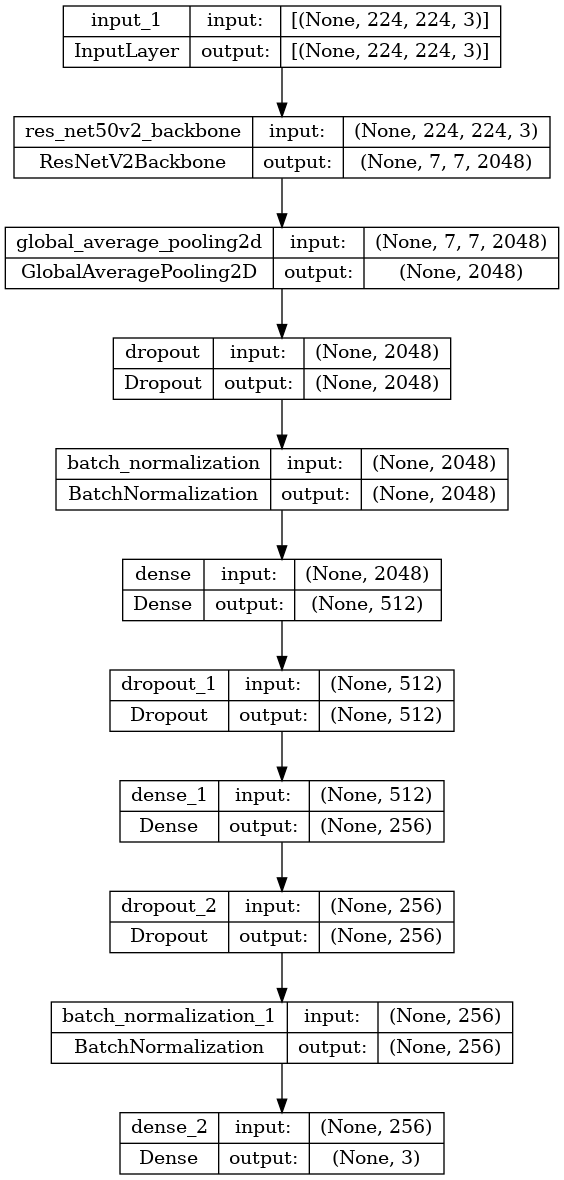

In [22]:
model = create_model()
keras.utils.plot_model(model, show_shapes=True)

# Callback function

用來記錄目前的 learning rate

In [23]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.lr

# Data visualization

In [24]:
dftrain, dfval = get_train_val_dataframes(configs['train_csv'])

train_ds = build_train_ds(dftrain)
val_ds = build_train_ds(dfval)


In [ ]:
visualize_dataset(test_ds, 'Validation Dataset (without Augmentation)')

## 測試 cutmix, mixup, cutmix_mixup 資料擴增的結果

In [ ]:
# 保留前 advanced_aug 的值
old_aug = configs['advanced_aug']
configs['advanced_aug'] = 'cutmix'
dftrain, dfval = get_train_val_dataframes(configs['train_csv'])

train_ds = build_train_ds(dftrain)
val_ds = build_train_ds(dfval)

visualize_dataset(train_ds, 'Train Dataset (with Augmentation + cutmix)')
#回存
configs['advanced_aug'] = old_aug

## 畫出 learning rate scheduling 的結果

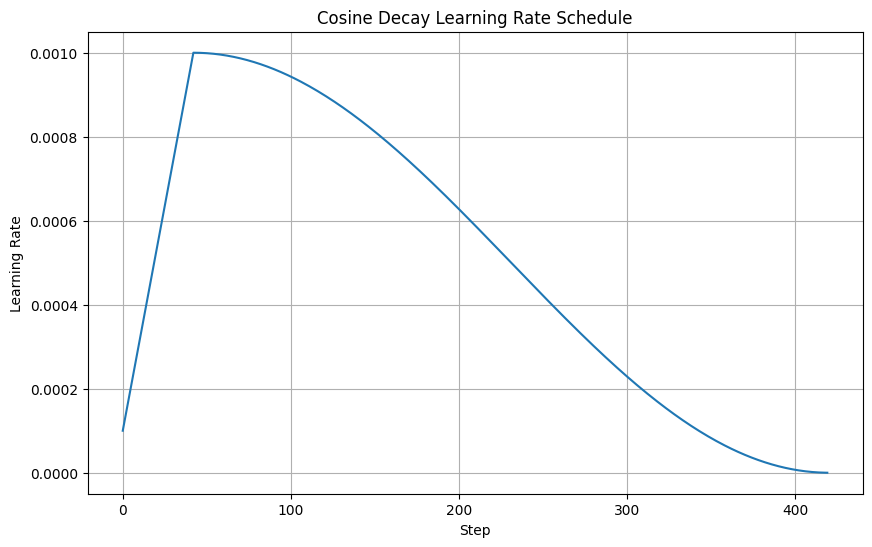

In [28]:
import matplotlib.pyplot as plt
import numpy as np

train_ds, _, _ = load_train_val_test_ds()
# Assuming the same parameters you used to create your cosine_decay instance
total_train_steps = len(train_ds) * configs['epochs']
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=configs['initial_learning_rate'],
    decay_steps=decay_steps,
    alpha=0.0,
    warmup_target=configs['warmup_learning_rate'],
    warmup_steps=warmup_steps,
)

# Create an array of step values
steps = np.arange(total_train_steps)

# Compute the learning rate for each step
lr_values = [cosine_decay(step).numpy() for step in steps]
#lr_values = cosine_decay(steps)

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(steps, lr_values)
plt.title('Cosine Decay Learning Rate Schedule')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


# Experiment 1

In [30]:
model_names = ['resnet50', 'efficientnet']
exp_prefix = 'exp1'
for mname in model_names:
    configs['model_name'] = mname
    print(f'Start {exp_prefix} with model {configs["model_name"]}...')
    run = wandb.init(project='mango-classification', 
                name=f'{exp_prefix}_{configs["model_name"]}',
                config=configs)
    CHECKPOINT = f"checkpoints/{exp_prefix}_model_{configs['model_name']}.h5"

    
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=2),
        WandbModelCheckpoint(filepath=CHECKPOINT, 
                        monitor='val_f1_score', 
                        mode = 'max', 
                        save_best_only=True,
                        save_weights_only=True,
                        options=None, 
                        verbose=1),
        LearningRateLogger(),
    ]
    wandb.run.summary['checkpoint'] = CHECKPOINT
    # 讀資料
    print(f'Loading the dataset....')
    train_ds, val_ds, test_ds = load_train_val_test_ds()
    #dftrain, dfval = get_train_val_dataframes(configs['train_csv'])
    #dftest = get_test_dataframe(configs['test_csv'])
    #train_ds = build_train_ds(dftrain)
    #val_ds = build_train_ds(dfval)
    #test_ds = build_test_ds(dftest)

    total_train_steps = len(train_ds) * configs['epochs']
    warmup_steps = int(total_train_steps * 0.10)
    decay_steps = total_train_steps - warmup_steps
    print(f"{total_train_steps=}")
    print(f"{warmup_steps=}")
    print(f"{decay_steps=}")
    print('Constructing the model...')
    model = create_model()
    # 參考 https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train
    cosine_decay = keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=configs['initial_learning_rate'],
            decay_steps=decay_steps,
            alpha=0.0,
            warmup_target=configs['warmup_learning_rate'],
            warmup_steps=warmup_steps,
        )

    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)

    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), 
            metrics=['accuracy', keras.metrics.CategoricalCrossentropy(label_smoothing=0.1), keras.metrics.F1Score(average='macro', dtype='float32')])


    h = model.fit(train_ds, validation_data=val_ds, 
        epochs=configs['epochs'], callbacks=wandb_callbacks)
    print('Evaluating the model...')

    # load best model from CHECKPOINT
    model.load_weights(CHECKPOINT)
    # evaluate model
    model.evaluate(test_ds) 
    # print test accuracy, f1 score
    y_pred = model.predict(test_ds)
    y_pred = np.argmax(y_pred, axis=1)
    dftest = get_test_dataframe(configs['test_csv'])
    y_true = dftest.label
    accuracy = accuracy_score(y_true, y_pred)
    recalls = recall_score(y_true, y_pred, average='macro')
    precisions = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Test accuracy: {accuracy}")
    print(f"Test f1 score: {f1}")
    print(f"Test recall score: {recalls}")
    print(f'Test precision score: {precisions}')
    print(h.history['lr'])
    
    wandb.run.summary['Test Acc'] = accuracy
    wandb.run.summary['Test F1'] = f1
    wandb.run.summary['Test Recall'] = recalls
    wandb.run.summary['Test Precision'] = precisions
    wandb.finish()
    # clear all keras session to free memory
    keras.backend.clear_session()
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.keras.backend.clear_session()
    del model
    del h
    del train_ds
    del val_ds
    del test_ds
    del dftest



Start exp1 with model resnet50...


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Loading the dataset....
total_train_steps=420
warmup_steps=42
decay_steps=378
Constructing the model...


/home/u7801832/.local/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/u7801832/.local/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Epoch 1/3


2024-05-21 12:20:10.702294: I external/local_xla/xla/service/service.cc:168] XLA service 0x5641461f08b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 12:20:10.702338: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-05-21 12:20:10.711972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
I0000 00:00:1716265210.780965    1918 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-21 12:20:11.605445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1716265221.655855    1918 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716265234.673437    1918 graph_launch.cc:671] Fallback to op

140/140 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.5853 - categorical_crossentropy: 1.0686 - f1_score: 0.5899

W0000 00:00:1716265288.722994    1917 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_f1_score improved from -inf to 0.16148, saving model to checkpoints/exp1_model_resnet50.h5
140/140 [==============================] - 93s 346ms/step - loss: 1.0686 - accuracy: 0.5853 - categorical_crossentropy: 1.0686 - f1_score: 0.5899 - val_loss: 1.2146 - val_accuracy: 0.3196 - val_categorical_crossentropy: 1.2146 - val_f1_score: 0.1615 - lr: 8.4613e-04
Epoch 2/3
140/140 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.6998 - categorical_crossentropy: 0.7961 - f1_score: 0.7042
Epoch 2: val_f1_score did not improve from 0.16148
140/140 [==============================] - 45s 317ms/step - loss: 0.7961 - accuracy: 0.6998 - categorical_crossentropy: 0.7961 - f1_score: 0.7042 - val_loss: 1.2897 - val_accuracy: 0.3196 - val_categorical_crossentropy: 1.2897 - val_f1_score: 0.1615 - lr: 3.0578e-04
Epoch 3/3
140/140 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.7460 - categorical_crossentropy: 0.7292 - f1_score: 0.7508
Epoch 3: val

W0000 00:00:1716265393.289148    1919 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 [==============================] - 5s 57ms/step
Test accuracy: 0.31
Test f1 score: 0.15776081424936386
Test recall score: 0.3333333333333333
Test precision score: 0.10333333333333333
[<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.7255546e-08>, <tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.7255546e-08>, <tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.7255546e-08>]


/home/u7801832/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


batch/accuracy,▁▃▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/categorical_crossentropy,██▇▆▆▆▆▅▅▅▅▅▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/f1_score,▁▃▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████
batch/learning_rate,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
batch/loss,██▇▆▆▆▆▅▅▅▅▅▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆█
epoch/categorical_crossentropy,█▂▁
epoch/epoch,▁▅█
epoch/f1_score,▁▆█
epoch/learning_rate,█▄▁


Start exp1 with model efficientnet...


Loading the dataset....
total_train_steps=420
warmup_steps=42
decay_steps=378
Constructing the model...


/home/u7801832/.local/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/u7801832/.local/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Epoch 1/3


2024-05-21 12:24:05.849598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficient_net_v2s_backbone/block1b_/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
W0000 00:00:1716265471.023320    1918 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-21 12:24:42.017350: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_1071', 32 bytes spill stores, 32 bytes spill loads

W0000 00:00:1716265487.425993    1920 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 [==============================] - ETA: 0s - loss: 1.1118 - accuracy: 0.5817 - categorical_crossentropy: 1.1118 - f1_score: 0.5842

W0000 00:00:1716265553.041984    1920 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_f1_score improved from -inf to 0.73362, saving model to checkpoints/exp1_model_efficientnet.h5
140/140 [==============================] - 140s 297ms/step - loss: 1.1118 - accuracy: 0.5817 - categorical_crossentropy: 1.1118 - f1_score: 0.5842 - val_loss: 0.7437 - val_accuracy: 0.7348 - val_categorical_crossentropy: 0.7437 - val_f1_score: 0.7336 - lr: 8.4613e-04
Epoch 2/3
140/140 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.7007 - categorical_crossentropy: 0.8096 - f1_score: 0.7048
Epoch 2: val_f1_score improved from 0.73362 to 0.74096, saving model to checkpoints/exp1_model_efficientnet.h5
140/140 [==============================] - 36s 254ms/step - loss: 0.8096 - accuracy: 0.7007 - categorical_crossentropy: 0.8096 - f1_score: 0.7048 - val_loss: 0.6924 - val_accuracy: 0.7393 - val_categorical_crossentropy: 0.6924 - val_f1_score: 0.7410 - lr: 3.0578e-04
Epoch 3/3
140/140 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7391 -

W0000 00:00:1716265643.819829    1919 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 [==============================] - 8s 38ms/step
Test accuracy: 0.77125
Test f1 score: 0.7742818339683749
Test recall score: 0.7812701353695416
Test precision score: 0.7743068517079141
[<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.7255546e-08>, <tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.7255546e-08>, <tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.7255546e-08>]


batch/accuracy,▁▂▃▄▄▄▅▅▅▅▅▅▅▅█▇▇▇▇▇▇▇▇▇▇▇▇█████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/categorical_crossentropy,█▆▆▅▅▅▄▄▄▄▄▄▃▃▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/f1_score,▁▂▃▄▄▄▅▅▅▅▅▅▅▅█▇▇▇▇▇▇▇▇▇▇▇▇█████████████
batch/learning_rate,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
batch/loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆█
epoch/categorical_crossentropy,█▂▁
epoch/epoch,▁▅█
epoch/f1_score,▁▆█
epoch/learning_rate,█▄▁
